/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning:

The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning:

Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.



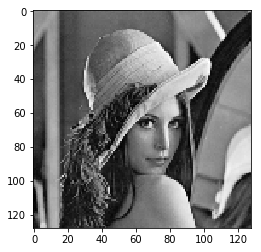

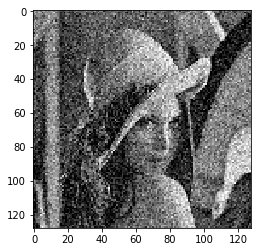

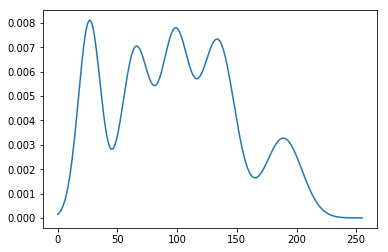

In [21]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from skimage.transform import rescale, resize
import imageio
from sklearn.mixture import GaussianMixture

def read_image(name):
    image = imageio.imread(name)
    image = resize(image,(128,128))
    image = 255 * image
    image = image.astype(np.uint8)
    data = image.ravel()
    return image, data

def show_image(image):
    image = np.array([image])
    image = np.reshape(image, (128,128))
    image = resize(image,(128,128))
    plt.imshow(image,cmap=cm.gray)
    plt.show()

def add_noise(data, sigma2):
    mean = 0
    gauss = np.random.normal(mean, sigma2, len(data))
    data = data + gauss
    data[data > 255] = 255
    data[data < 0] = 0
    return data

def compute_gmm(image, pixel_values):
    gmm = GaussianMixture(n_components = 5)
    gmm = gmm.fit(X=np.expand_dims(image.flatten(),1))
    gmm_x = np.array(pixel_values).reshape(-1,1)
    gmm_y = np.exp(gmm.score_samples(gmm_x.reshape(-1,1)))
    plt.plot(gmm_x, gmm_y)
    plt.show

def create_histogram(image):
    histo = np.histogram(image.flatten(), range=(0, 255), bins = 255)
    histo0 = np.concatenate(([0], histo[0]), axis=0)
    prob_x_ij = histo0/np.sum(histo0)
    pixel_values = histo[1].astype(int)
    return prob_x_ij, pixel_values

def create_p_y_x(data, sigma2):
    p_y_x_mat = []
    for i in data:
        y_j_dist = np.random.normal(i, sigma2, len(data))
        his_y = np.histogram(y_j_dist, range=(0, 255), bins = 255)
        his_y = np.concatenate(([0], his_y[0]), axis=0)
        prob_y_ij = his_y/np.sum(his_y)
        p_y_x_mat.append(prob_y_ij)
    p_y_x_mat = np.array(p_y_x_mat)
    return p_y_x_mat.T

def create_p_x_x(data, pix_var):
    p_x_x_mat = []
    for i in data:
        x_j_dist = np.random.normal(i, pix_var, len(data))
        his_x = np.histogram(x_j_dist, range=(0, 255), bins = 255)
        his_x = np.concatenate(([0], his_x[0]), axis=0)
        prob_x_ij = his_x/np.sum(his_x)
        p_x_x_mat.append(prob_x_ij)
    p_x_x_mat = np.array(p_x_x_mat)
    return p_x_x_mat.T

def compute_dist_bet_pix(data):
    dist_bet_pix_vec = []
    for k in np.arange(1,len(data)):
        dist_bet_pix = np.abs(int(data[k-1])-int(data[k]))
        dist_bet_pix_vec.append(dist_bet_pix)
    dist_bet_pix_vec = np.array(dist_bet_pix_vec)
    av_dist_pix = sum(dist_bet_pix_vec)/len(dist_bet_pix_vec)
    return av_dist_pix
    

def create_chi_matrix(prob_x_ij, p_y_x_mat, p_x_x_mat):
    prob_x_ij = np.array(prob_x_ij)
    chi_matrix = p_y_x_mat
    chi_matrix[:,0] = prob_x_ij*chi_matrix[:,0]
    for t in np.arange(1,chi_matrix.shape[1]):
        chi_matrix[:,t] = chi_matrix[:,t]+np.max(chi_matrix[:, t-1]+p_x_x_mat[:, t])
    return chi_matrix
    
def denoised_image(chi_matrix, p_x_x_mat):
    I = np.zeros((1,chi_matrix.shape[1]))
    I[:,0] = 100
    for t in np.arange(chi_matrix.shape[1]-1, 1,-1):
        I[:,t] = np.argmax(chi_matrix[:,t-1]+p_x_x_mat[:,t])
    return I

def MSE(denoised_image, image):
    image = np.array([image])
    image = image.reshape(128,128)
    denoised_image = np.array([denoised_image])
    denoised_image = denoised_image.reshape(128,128)
    mse = ((denoised_image - image)**2).mean(axis=None)
    return mse

if __name__=="__main__":
    name="/Users/johanabrahamsson/Documents/Machine learning and data science/Python/lena_gray.jpg"
    image, data = read_image(name)
    show_image(image)
    sigma2 = 30
    noisy_image = add_noise(data, sigma2)
    show_image(noisy_image)
    prob_x_ij, pixel_values = create_histogram(image)
    compute_gmm(image, pixel_values)
    
    
    """"
    prob_x_ij, pixel_values = create_histogram(image)
    prob_y_ij, pixel_values = create_histogram(noisy_image)
    p_y_x_mat = create_p_y_x(noisy_image, sigma2)
    var = compute_dist_bet_pix(data)
    p_x_x_mat = create_p_x_x(data, var)
    chi_matrix = create_chi_matrix(prob_x_ij, p_y_x_mat, p_x_x_mat)
    I = denoised_image(chi_matrix, p_x_x_mat)
    show_image(I)
    mse = MSE(I, image)
    print("MSE =", mse)
    """
    


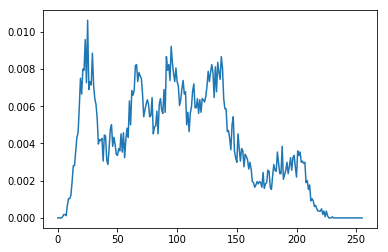

(256, 1)


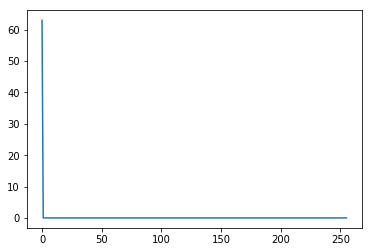

In [13]:
import plotly.plotly as py
import plotly.tools as tls
import operator
from sklearn.mixture import GaussianMixture
import numpy as np

#print(min(image2.flatten()), np.max(image2.flatten()))
histo = np.histogram(image.flatten(), range=(0, 255), bins = 255)

histo0 = np.concatenate(([0], histo[0]), axis=0)

prob_x_ij = histo0/np.sum(histo0)
pixel_values = histo[1]
plt.plot(pixel_values, prob_x_ij)
plt.show()

#print(sum(pixel_values*prob_x_ij))

#plt.figure()
#plt.scatter(pixel_values, prob_x_ij)

#n, bins, patches = plt.hist(image.flatten(), range=(0,255), bins = 255, density = True,facecolor='g', alpha=0.75)



data = np.array(prob_x_ij).reshape(-1,1)
gmm = GaussianMixture(n_components=6, covariance_type='full')
gmm = gmm.fit(data)

# Evaluate GMM
x = np.array(pixel_values).reshape(-1,1)
gmm_y = np.exp(gmm.score_samples(x))

plt.plot(y,gmm_y)
plt.show()


0.9996100680109784


'\n# Plot histograms and gaussian curves\nfig, ax = plt.subplots()\nax.hist(imag.ravel(),255,[0,255], normed=True)\nax.plot(gmm_x, gmm_y, color="crimson", lw=4, label="GMM")\n\nax.set_ylabel("Frequency")\nax.set_xlabel("Pixel Intensity")\n\nplt.legend()\n\nplt.show()\n'

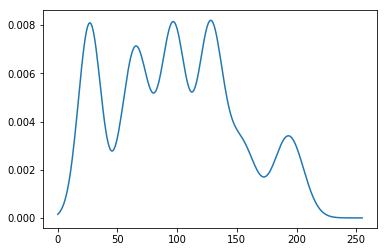

In [17]:
gmm = GaussianMixture(n_components = 6)
gmm = gmm.fit(X=np.expand_dims(image.flatten(),1))
gmm_x = np.array(pixel_values).reshape(-1,1)
gmm_y = np.exp(gmm.score_samples(gmm_x.reshape(-1,1)))
plt.plot(gmm_x, gmm_y)
plt.show

